# Prepping data

In [1]:
import pysr
from pysr import PySRRegressor

import xarray as xr
import netCDF4 as nc
#import h5netcdf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from glob import glob
import seaborn as sns

import os

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
folder_path = '/home/laurapong321/leap_24/les_sim_2'

#getting the correct dimension values
nc_test1 = nc.Dataset(os.path.join(folder_path, 'Ug2Q010_I.nc'), mode='r')
z_256 = nc_test1.variables['z'][:]
zh_257 = nc_test1.variables['zh'][:]
t_120 = nc_test1.variables['time'][:]
#rewrite this code but using 'Ug2Q010_IV.nc' instead
nc_test2 = nc.Dataset(os.path.join(folder_path, 'Ug2Q010_IV.nc'), mode='r')
z_384 = nc_test2.variables['z'][:]
zh_385 = nc_test2.variables['zh'][:]
t_90 = nc_test2.variables['time'][:]
print(len(z_256), len(zh_257), len(t_120), len(z_384), len(zh_385), len(t_90))

256 257 120 384 385 90


In [3]:
def read_data(filepath):
    """
    Reads in each dataset and returns an xarray dataset
    """

    #reading in the data for each group
    ds_thm = xr.open_dataset(f"{filepath}",
                             decode_times=False, group="thermo")
    ds_bud = xr.open_dataset(f"{filepath}",
                            decode_times=False, group="budget")
    ds_def = xr.open_dataset(f"{filepath}", 
                             decode_times=False, group="default")
    ds = xr.merge([ds_thm, ds_bud, ds_def], join="inner")


    #assigning the correct dims
    if len(ds.time) == 90:
        ds = ds.assign_coords({"time": t_90}).swap_dims({"time":"time"})
    elif len(ds.time) == 120:
        ds = ds.assign_coords({"time": t_120}).swap_dims({"time":"time"})

    if len(ds.z) == 256:
        ds = ds.assign_coords({"z": z_256}).swap_dims({"z":"z"})
    elif len(ds.z) == 384:
        ds = ds.assign_coords({"z": z_384}).swap_dims({"z":"z"})

    if len(ds.zh) == 257:
        ds = ds.assign_coords({"zh": zh_257}).swap_dims({"zh":"zh"})
    elif len(ds.zh) == 385:
        ds = ds.assign_coords({"zh": zh_385}).swap_dims({"zh":"zh"})
    
    return ds

In [4]:
def find_jump(ds, filter_num=.001):
    """
    Returns a dataset with the new variable
    del_th_sd, del_sft, del_eft with only the time coordinate
    """
    #making an array to store all the values of th_jump
    th_jump = np.array([])
    sft_jump = np.array([])
    eft_jump = np.array([])

    #prepping ds
    ds_jump = ds.copy()
    ds_jump = ds_jump[["th", "eft", "sft"]]

    #looping through every time and calculating th_jump
    for i in range(len(ds_jump.time)):

        #calculating the second derivate using np.diff
        #(central diff)
        diff_df = np.diff(ds_jump.isel(time=i).th, n=2)

        #putting the array into a dataframe to preserve the index
        #(height var)
        diff_df = pd.DataFrame(diff_df)
        diff_df = diff_df.reset_index()
        diff_df = diff_df.rename(columns={"index": "z", 0:"sec_der"})

        #chopping off the beginning and end of the df
        diff_df = diff_df.iloc[50:350]

        #filtering the df to only select for heights
        #with big enough second derivatives
        diff_df = diff_df[np.abs(diff_df["sec_der"]) >= filter_num]

        if len(diff_df) == 0:
            return "Try different filter num, everything filtered out"
        

        #getting the heights
        if (diff_df.z.iloc[1] - diff_df.z.iloc[0]) <= 1:
            min_z = diff_df.z.iloc[0]
        #making sure to cut off tails of sparse values
        else:
            j = 1
            while (diff_df.z.iloc[j+1] - diff_df.z.iloc[j]) >= 2:
                min_z = diff_df.z.iloc[j]
                j+=1

        
        if (diff_df.z.iloc[-1] - diff_df.z.iloc[-2]) <= 1:
            max_z = diff_df.z.iloc[-1]
        #making sure to cut off tails of sparse values
        else:
            j=-2
            while (diff_df.z.iloc[j] - diff_df.z.iloc[j-1]) >=2:
                max_z = diff_df.z.iloc[j]
                j-=1
        
        #calc th_jump
        jump_th = (ds_jump.isel(time=i, z=max_z).th.values - ds_jump.isel(time=i, z=min_z).th.values)
        jump_sft = (ds_jump.isel(time=i, z=max_z).sft.values - ds_jump.isel(time=i, z=min_z).sft.values)
        jump_eft = (ds_jump.isel(time=i, z=max_z).eft.values - ds_jump.isel(time=i, z=min_z).eft.values)

        #adding values to array
        if len(th_jump) == 0:
            th_jump = np.array([jump_th])
            sft_jump = np.array([jump_sft])
            eft_jump = np.array([jump_eft])
        else:
            th_jump = np.concatenate((th_jump, np.array([jump_th])))
            sft_jump = np.concatenate((sft_jump, np.array([jump_sft])))
            eft_jump = np.concatenate((eft_jump, np.array([jump_eft])))

    if len(th_jump) != len(ds_jump.time):
        return "Error in code"
    
    #adding array of th_jumps to the original ds, index is time
    ds = ds.assign(del_th_sd=(['time'],th_jump))
    ds = ds.assign(del_sft_sd=(["time"], sft_jump))
    ds = ds.assign(del_eft_sd=(["time"], eft_jump))


    return ds
    

In [5]:
def prep_ds(ds, ug, filter_num_sd=.001):
    """
    Makes an xarray dataset with all the necesscary variables for
    equation discovery"""

    ds_return = ds.copy()
    #selecting necessary vars
    ds_return = ds_return[["zi", "th", "th_flux", "b_flux",
                        "sft", "sft_flux", "eft", "eft_flux"]]

    #calc dh/dt
    dt = ds_return.time.isel(time=1).values - ds_return.time.isel(time=0).values
    bl_evo = np.gradient(ds_return.zi, int(dt))
    #adding dh/dt to ds
    ds_return = ds_return.assign(dh_dt=(['time'],bl_evo))

    #finding del_th
    ds_return = find_jump(ds_return, filter_num_sd)
    
    #making surface b_flux
    ds_return["b_flux_sfc"] = ds_return.b_flux.sel(zh=0)

    #making u_g var
    u_g = ug*np.ones((ds_return.time.shape))
    ds_return = ds_return.assign(u_g=(["time"], u_g))

    #finding th_flux min
    ds_return["th_flux_min"] = ds_return.th_flux.min(dim="zh")

    #finding h_minus
    ds_return["h_minus"] = xr.where(ds_return["th_flux_min"],
                                     ds_return.isel(zh=ds_return.th_flux.argmin(dim="zh")).zh, 
                                     np.nan)
    
    #finding flux of sft at h_minus
    ds_return["sft_flux_min"] = ds_return.sft_flux.min(dim="zh")
    
    #finding flux of eft at h_minus
    ds_return["eft_flux_min"] = ds_return.eft_flux.min(dim="zh")

    #finding we from the discovered equation
    ds_return["we"] = 9.961432*ds_return["b_flux_sfc"]/ds_return["del_th_sd"] + 0.0009702546*ds_return["u_g"]

    #finding h deft/dt
    eft_evo = np.gradient(ds_return.isel(z=75).eft, int(dt))
    ds_return = ds_return.assign(deft_dt=(['time'],eft_evo))
    ds_return["h_deft_dt"] = ds_return.zi * ds_return.deft_dt

    #calc we*del_eft from assumption
    ds_return["we_del_eft"] = ds_return["we"]*ds_return["del_eft_sd"]

    #resampling using coarsen across all variables
    ds_return = ds_return.coarsen(time=15).mean()
    
    return ds_return
    

In [6]:
#opening data
folder_path = '/home/laurapong321/leap_24/les_sim_2'

files = glob(f"{folder_path}/*")

iv16_1 = read_data(files[1])
iv16_3 = read_data(files[2])
i16_6 = read_data(files[3])
iv16_6 = read_data(files[4])
iv16_10 = read_data(files[5])
ii10_1 = read_data(files[6])
i2_20 = read_data(files[7])
iv2_10 = read_data(files[8])
iii2_1 = read_data(files[9])
i2_24 = read_data(files[10])
iii8_3 = read_data(files[11])
ii8_3 = read_data(files[12])
iv8_3 = read_data(files[13])
iv8_6 = read_data(files[14])

In [7]:
#prepping all the simulations for sr
iv16_1_ed = prep_ds(iv16_1, 16, filter_num_sd=.001)
iv16_3_ed = prep_ds(iv16_3, 16, filter_num_sd=.00075)
i16_6_ed = prep_ds(i16_6, 16, filter_num_sd=.0002)
iv16_6_ed = prep_ds(iv16_6, 16)
iv16_10_ed = prep_ds(iv16_10, 16)
ii10_1_ed = prep_ds(ii10_1, 10)
i2_20_ed = prep_ds(i2_20,2, filter_num_sd=.00025)
iv2_10_ed = prep_ds(iv2_10, 2)
iii2_1_ed = prep_ds(iii2_1, 2)
i2_24_ed = prep_ds(i2_24, 2, filter_num_sd=.002)
iii8_3_ed = prep_ds(iii8_3, 8)
ii8_3_ed = prep_ds(ii8_3, 8)
iv8_3_ed = prep_ds(iv8_3, 8)
iv8_6_ed = prep_ds(iv8_6, 8)

### EFT and SFT

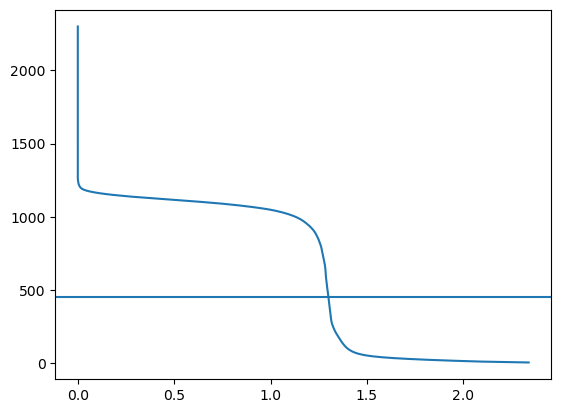

In [8]:
plt.plot(iv8_6.sft.isel(time=119), iv8_6.z)
plt.axhline(iv8_6.isel(time=0, z=75).z)
#plt.ylim(0, 1000)
#plt.xlim(.7,.9)

In [9]:
iv8_6.eft.isel(z=75)

<xarray.DataArray 'eft' (time: 120)>
[120 values with dtype=float64]
Coordinates:
  * time     (time) float64 7.26e+03 7.32e+03 7.38e+03 ... 1.434e+04 1.44e+04
    z        float64 453.0
Attributes:
    units:      -
    long_name:  eft

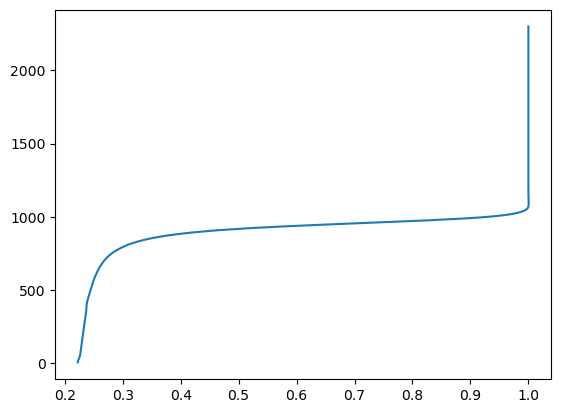

In [10]:
plt.plot(iv8_6.eft.isel(time=0), iv8_6.z)
#plt.ylim(0, 1000)
#plt.xlim(.7,.9)

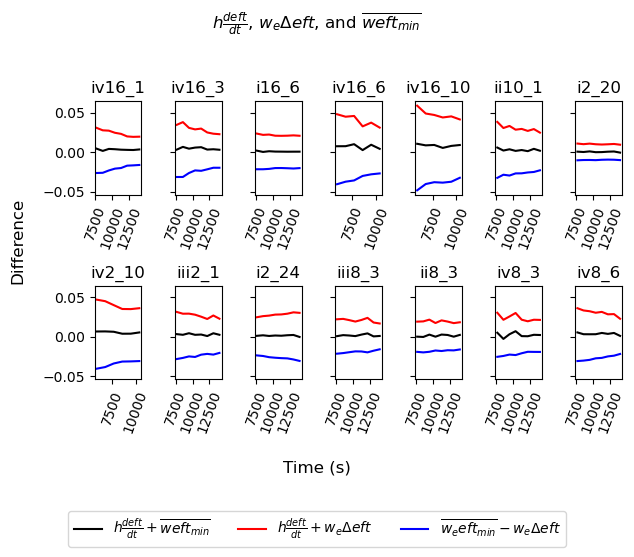

In [18]:
sim_list = [iv16_1_ed, iv16_3_ed, i16_6_ed,
            iv16_6_ed, iv16_10_ed, ii10_1_ed,
            i2_20_ed, iv2_10_ed, iii2_1_ed,
             i2_24_ed, iii8_3_ed, ii8_3_ed, 
            iv8_3_ed, iv8_6_ed]

sim_list_str = ["iv16_1", "iv16_3", "i16_6",
                "iv16_6", "iv16_10", "ii10_1",
                "i2_20", "iv2_10", "iii2_1",
                "i2_24", "iii8_3", "ii8_3", 
                "iv8_3", "iv8_6"]

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7), (ax8, ax9, ax10, ax11, ax12, ax13, ax14)) = plt.subplots(2, 7, sharey=True)#, figsize=(20, 10))

fig.suptitle("$h\\frac{{deft}}{{dt}}$, $w_e\\Delta eft$, and $\\overline{w eft_{min}}$")
fig.supxlabel("Time (s)")
fig.supylabel("Difference")

ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7,
           ax8, ax9, ax10, ax11, ax12, ax13, ax14]

# Define legend labels and colors
legend_labels = ["$h\\frac{{deft}}{{dt}} + \\overline{w eft_{min}}$", 
                 "$h\\frac{{deft}}{{dt}} + w_e\\Delta eft$", 
                 "$\\overline{w_e eft_{min}} - w_e\\Delta eft$"]
colors = ["k", "r", "b"]

for i in range(len(sim_list)):
    ax_list[i].plot(sim_list[i].time, (sim_list[i].h_deft_dt + sim_list[i].eft_flux_min), color=colors[0], label=legend_labels[0])
    ax_list[i].plot(sim_list[i].time, (sim_list[i].h_deft_dt + sim_list[i].we_del_eft), color=colors[1], label=legend_labels[1])
    ax_list[i].plot(sim_list[i].time, (sim_list[i].eft_flux_min - sim_list[i].we_del_eft), color=colors[2], label=legend_labels[2])
    ax_list[i].set_title(sim_list_str[i])
    ax_list[i].tick_params(axis='x', labelrotation=70)

# Add a single legend for the entire figure
handles, labels = ax_list[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()


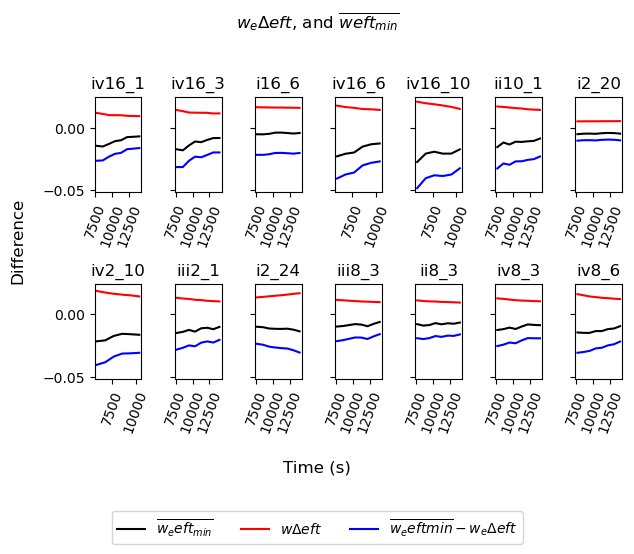

In [15]:
sim_list = [iv16_1_ed, iv16_3_ed, i16_6_ed,
            iv16_6_ed, iv16_10_ed, ii10_1_ed,
            i2_20_ed, iv2_10_ed, iii2_1_ed,
             i2_24_ed, iii8_3_ed, ii8_3_ed, 
            iv8_3_ed, iv8_6_ed]

sim_list_str = ["iv16_1", "iv16_3", "i16_6",
                "iv16_6", "iv16_10", "ii10_1",
                "i2_20", "iv2_10", "iii2_1",
                "i2_24", "iii8_3", "ii8_3", 
                "iv8_3", "iv8_6"]

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7), (ax8, ax9, ax10, ax11, ax12, ax13, ax14)) = plt.subplots(2, 7, sharey=True)#, figsize=(20, 10))

fig.suptitle("$w_e\\Delta eft$, and $\\overline{w eft_{min}}$")
fig.supxlabel("Time (s)")
fig.supylabel("Difference")

ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7,
           ax8, ax9, ax10, ax11, ax12, ax13, ax14]

# Define legend labels and colors
legend_labels = ["$\\overline{w_e eft_{min}}$", 
                 "$w\\Delta eft$", 
                 "$\\overline{w_e eft{min}} - w_e\\Delta eft$"]
colors = ["k", "r", "b"]

for i in range(len(sim_list)):
    ax_list[i].plot(sim_list[i].time, (sim_list[i].eft_flux_min), color=colors[0], label=legend_labels[0])
    ax_list[i].plot(sim_list[i].time, ( sim_list[i].we_del_eft), color=colors[1], label=legend_labels[1])
    ax_list[i].plot(sim_list[i].time, (sim_list[i].eft_flux_min - sim_list[i].we_del_eft), color=colors[2], label=legend_labels[2])
    ax_list[i].set_title(sim_list_str[i])
    ax_list[i].tick_params(axis='x', labelrotation=70)

# Add a single legend for the entire figure
handles, labels = ax_list[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()
